In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar xvfz cifar-10-python.tar.gz

--2020-05-10 08:20:57--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: 'cifar-10-python.tar.gz'

cifar-10-python.tar  94%[=================>  ] 154.32M   124KB/s    eta 48s    

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data

Using TensorFlow backend.


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
files = [
    "cifar-10-batches-py/data_batch_1",
    "cifar-10-batches-py/data_batch_2",
    "cifar-10-batches-py/data_batch_3",
    "cifar-10-batches-py/data_batch_4",
    "cifar-10-batches-py/data_batch_5",
]

images = []
grays = []
labels = []
for file in files:
    datas = unpickle(file)
    print(datas.keys())
    for (data, label) in zip(datas[b'data'], datas[b'labels']):
        image = []
        gray  = []
        r = data[0:1024]
        g = data[1024:2048]
        b = data[2048:3072]
        for rgb in zip(r,g,b):
            image.append(rgb)
            pixel = rgb[0] * 0.3 + rgb[1] * 0.59 + rgb[2] * 0.11
            gray.append(pixel)
        images.append(image)
        grays.append(gray)
        labels.append(label)
    
        


dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [4]:
label_texts = unpickle("cifar-10-batches-py/batches.meta")
label_texts = label_texts[b'label_names']


In [5]:
label_texts

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [6]:
images = np.array(images)
grays  = np.array(grays)

In [7]:


def view_images(images, grays, labels, index):
    label = labels[index]
    image = images[index].reshape([32,32,3])
    gray  = grays[index].reshape([32,32])
   
    plt.title(f'Example: {index}  Label: {label_texts[label]}' )
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(gray, cmap=plt.get_cmap('gray'))
    plt.show()
    

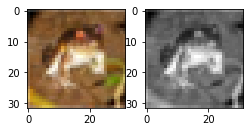

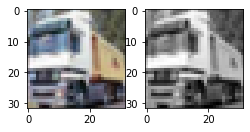

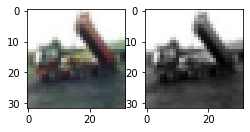

In [8]:

for i in range(3):
    view_images(images, grays, labels, i)


In [9]:
import cv2
gray_resizeds = []
for i, gray in enumerate(grays):
    gray_resized = cv2.resize(np.array(gray).reshape(32,32), (28,28))
    gray_resized /= 255
    gray_resizeds.append(gray_resized)
    
    

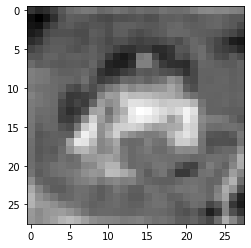

In [10]:
plt.imshow(gray_resizeds[0], cmap=plt.get_cmap('gray'))
plt.show()


In [11]:
np.min(gray_resizeds), np.max(gray_resizeds)

(0.0, 1.0)

In [12]:
len(gray_resizeds), len(labels)

(50000, 50000)

In [13]:
X_train, y_train = np.array(gray_resizeds[0:45000]), labels[0:45000]
X_valid, y_valid = np.array(gray_resizeds[45000:] ), labels[45000:]


In [14]:
X_train_keras = X_train.reshape(45000,28,28,1)
y_train_keras = to_categorical(y_train)

X_valid_keras = X_valid.reshape(5000,28,28,1)
y_valid_keras = to_categorical(y_valid)



In [15]:
# Confirm use of GPU
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else: print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [16]:
# DCGAN

In [17]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model
        
    def generator(self, depth=256, dim=7, dropout=0.3, momentum=0.8, \
                  window=5, input_dim=100, output_depth=1):
        if self.G:
            return self.G
        self.G = Sequential()
        self.G.add(Dense(dim*dim*depth, input_dim=input_dim))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/16), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(output_depth, window, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator(self, depth=64, dropout=0.3, alpha=0.3):
        if self.D:
            return self.D
        self.D = Sequential()
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,
            padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*16, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.AM
        
class MNIST_DCGAN(object):
    def __init__(self, x_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = x_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0, self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], \
                                                      a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, \
                        samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, \
                    noise=None, step=0):
        current_path = os.getcwd()
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            file = os.path.join('images', filename)
            os.makedirs(os.path.dirname(file), exist_ok=True)
            plt.savefig(file)
            plt.close('all')
        else:
            plt.show()

In [18]:
# Initialize MNIST DCGAN and train
mnist_dcgan = MNIST_DCGAN(X_train_keras)
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=200000, batch_size=256, save_interval=500)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_______________________________________

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-345c752fbc85>", line 4, in <module>
    mnist_dcgan.train(train_steps=200000, batch_size=256, save_interval=5)
  File "<ipython-input-17-50eafaed5534>", line 141, in train
    a_loss = self.adversarial.train_on_batch(noise, y)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/training.py", line 1514, in train_on_batch
    outputs = self.train_function(ins)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/backend.py", line 3476, in __call__
    run_metadata=self.run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py", line 1472, in __call__
    run_metadata_ptr)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  Fil

KeyboardInterrupt: 

In [ ]:
# Generate batch of synthetic MNIST images
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)